# Data screening, multi-variate analysis and clustering

In this chapter, you will analyze data from a large study investigating breast cancer subtypes (https://www.nature.com/articles/s41467-019-09018-y).

![](resources/images/CancerPaperAbstract.png)

The following topics are covered in this jupyter notebook:

- Reading data into R
- Basic visualization of relative protein abundances
- General data properties
- Principal component analysis to identify general trends
- Hierarchical clustering to groups co-regulated proteins
- Variance-sensitive cluster analysis using the VSClust app

For some accompanying slides, see http://computproteomics.bmb.sdu.dk/tmp/QuantWorkshop/#48


### Reading the data

We will start by loading the data and visualize it carefully, also to find out how to proceed with the analysis.

The next code fragments helps you to upload the file _PMC6453966.csv_ into R and look at its content. It is located in the subfolder _resources/data_.

Also take a look into the original file of the paper: Supplementary table 1 in https://www.nature.com/articles/s41467-019-09018-y

<span style="background-color:#ddffdd;border-left:6px;">Task:</span>    
👨‍💻 Find the experimental design in the paper and/or data that allows assigning channels to tumor types.

In [ ]:
# Some installation
# Comment the following line with "#" afterwards 
install.packages("pheatmap")
library(pheatmap)


rQuantTable <-read.csv("resources/data/PMC6453966.csv",row.names=1)

# Which columns are there?
cat("---- Column names: ----\n")
colnames(rQuantTable)

options(repr.matrix.max.cols = 100)
head(rQuantTable)

#Take only protein abundances
# Add correct numbers for first_col and last_col
first_col <- 34
last_col <- 34+9*5
QuantTable <- rQuantTable[, first_col:last_col]


# Assign tumor types by reading the file PMC6453966TumorTypes.csv
TCateg <- read.csv("resources/data/PMC6453966TumorTypes.csv")
cat("---- New column names: ----\n")
colnames(TCateg)
colnames(QuantTable) <- paste(TCateg$PAM50.subtype, "Sample", 1:45)
QuantTable <- QuantTable[,sort(colnames(QuantTable))]
head(QuantTable)


#### Add your answers here
(double-click here to edit the cell)

##### ❔ Question I:  <ins>What do the different columns contain? How many cancer subtypes and how many replicates?</ins>

_Answer_

##### ❔ Question II:  <ins>What is in channel 131?</ins>

_Answer_

##### ❔ Question II:  <ins>Is the data log-transformed? How would you check that?</ins>

_Answer_



### Visualization

We want to understand the data better by visualization. This helps also to identify important properties that might not be clear from the data description.

[Boxplots](https://en.wikipedia.org/wiki/Box_plot) are useful for roughly comparing the vdistributions of the different samples. For even nicer visualization, use violin plots.  
A [histogram](https://en.wikipedia.org/wiki/Histogram) shows the distribution of values by binning them.  
Scatter plots allow direct comparison of the values between 2 samples


_Tasks:_  
👨‍💻 Make a boxplot and discuss how and why it looks like that.   
👨‍💻 Visualize the distribution of some of the channels and also compare them via a scatter plot.  
👨‍💻 Repeat the same for the log-transformed data.  
👨‍💻 Calculate the dynamics range of all values.

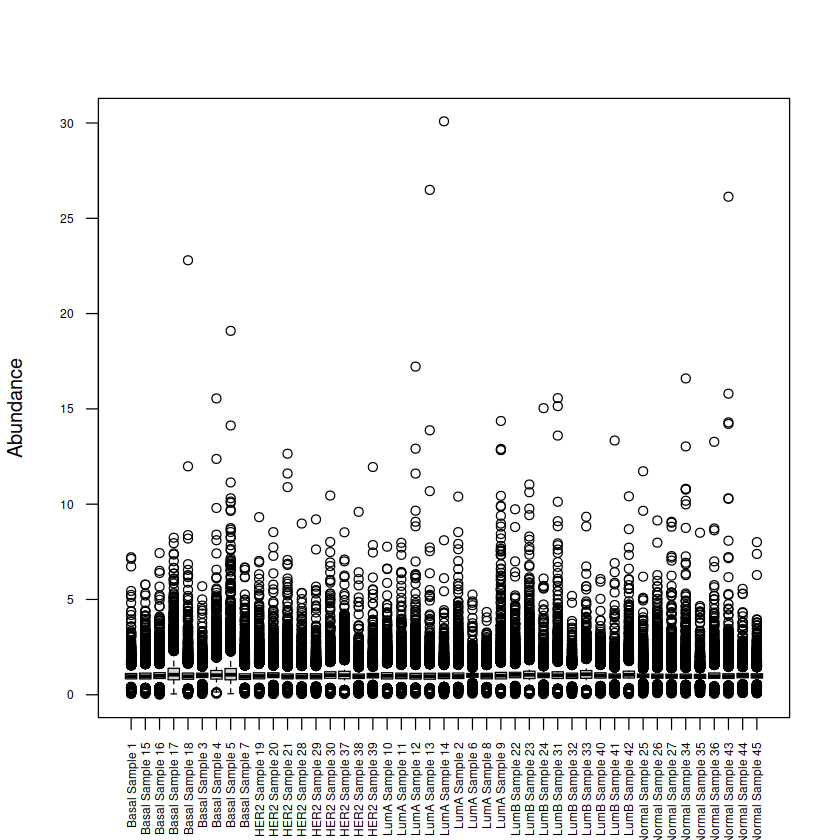

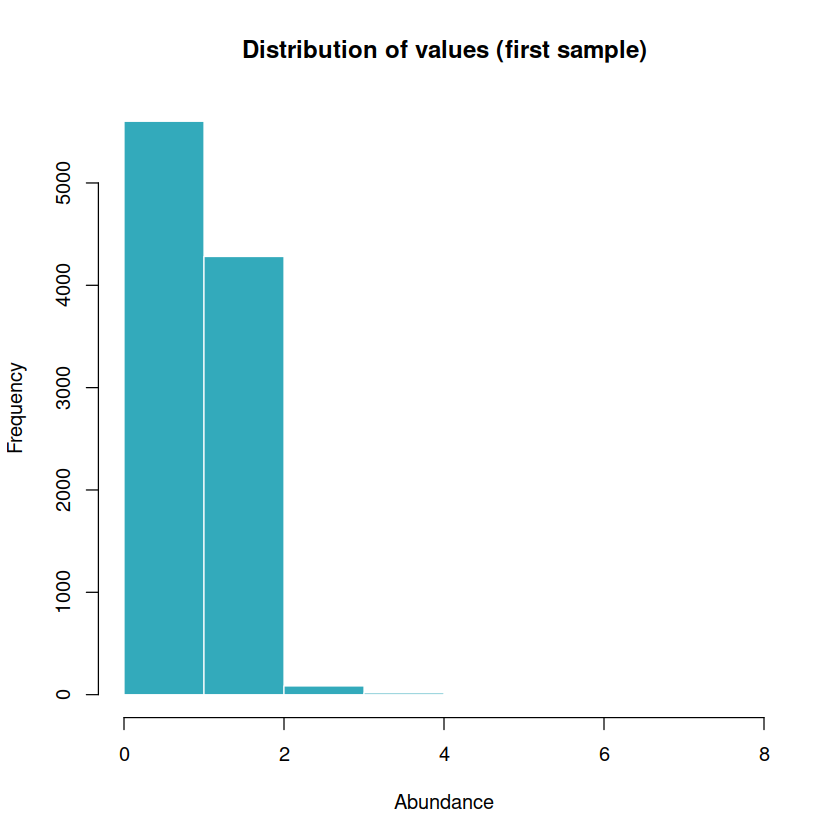

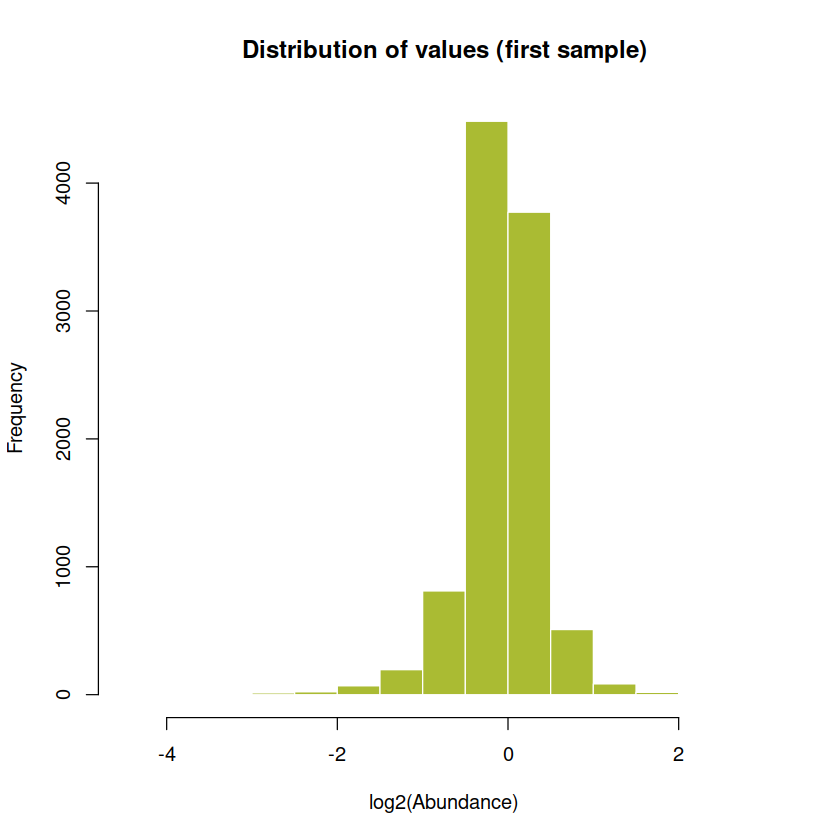

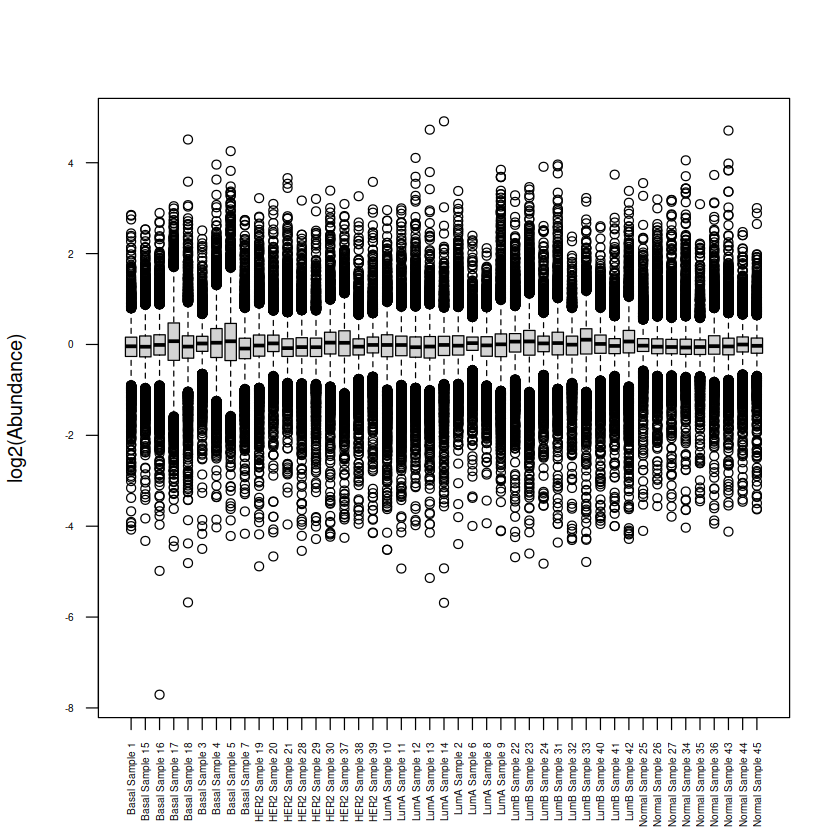

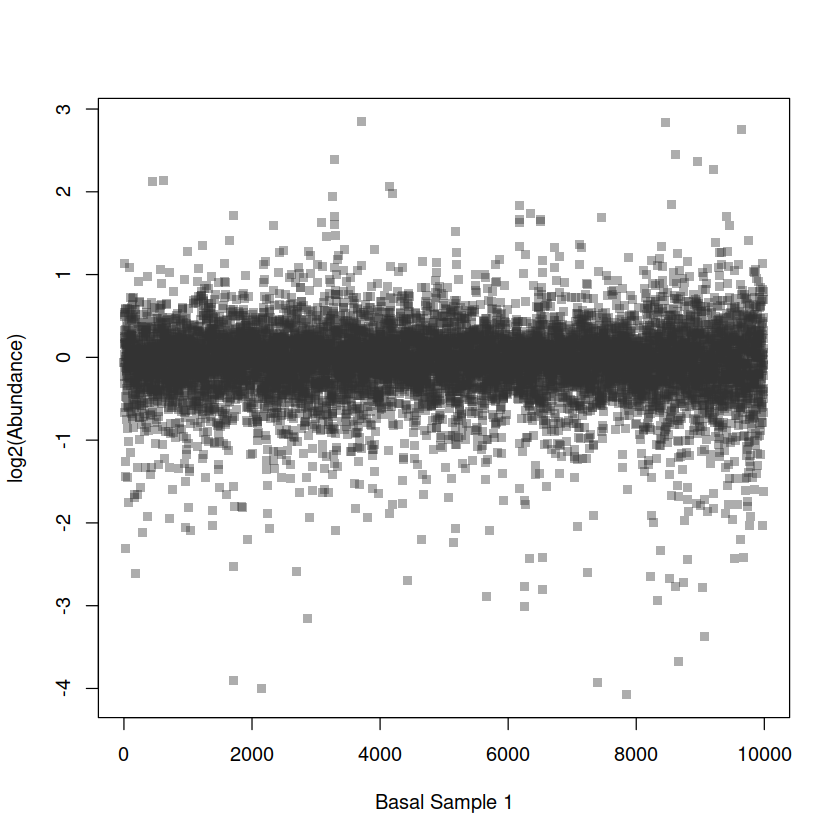

In [52]:
# some figures
boxplot(QuantTable, las=2, cex.axis=0.6, ylab="Abundance")

# Change the number of bins to find a nicer visualization
numBin <- 10
hist(QuantTable[,1],numBin, main="Distribution of values (first sample)", xlab="Abundance", col="#33AABB", border=0)

# Why is the distribution so assymetric? Take log?
hist(log2(QuantTable[,1]),numBin, main="Distribution of values (first sample)", xlab="log2(Abundance)", col="#AABB33", border=0)

# log-trafo
lQuantTable <- log2(QuantTable)
boxplot(lQuantTable, cex.axis=0.5, las=2, ylab="log2(Abundance)")

# scatter plot
sample_to_plot <- "Basal Sample 1"
plot(lQuantTable[,sample_to_plot], pch=15, col="#33333366", xlab=sample_to_plot, ylab="log2(Abundance)")



#### Add your answers here
(double-click here to edit the cell)

##### ❔ Question I:  <ins>The data seems to centered. Around which value?</ins>

_Answer_

##### ❔ Question II:  <ins>Which normalization was used by the authors of the paper? On which data level (PSMs, peptides, proteins)? How is that visible in the plots</ins>

_Answer_

##### ❔ Question III:  <ins>Any idea why the distribution is so sharp?</ins>

_Answer_


##### ❔ Question IV:  <ins>Why can't you see any linear relationship between the samples?</ins>

_Answer_




### Dynamic range, similarity and missing values

In the following, we will calculate the dynamic range of the full data and get more insight into data similarity by calculating correlations. We also assess the number of missing values

Missing values in proteomics data are a big problem. Value imputation, particularly wrong imputation will create bias in the statistical analysis.

[1] "The range is: 6291.01140440272"


   0 
9995 

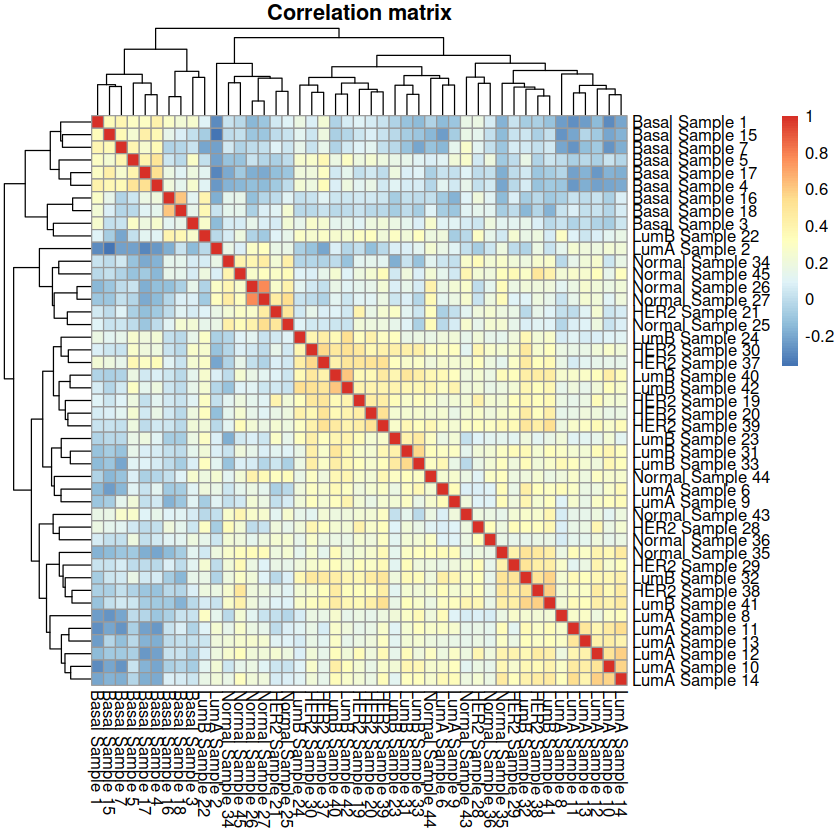

In [53]:
# What is the dynamics range of the data?
# the functions min and max calculate the smallest (largest) value of an entire table. 
paste("The range is:",2^(max(lQuantTable)-min(lQuantTable)))

# Correlations between samples, replicates should show higher correlations
pheatmap(cor(lQuantTable), main="Correlation matrix", scale="none", 
         fontsize_row=10, fontsize_col=10)

# Number of missing values per column
table(rowSums(is.nan(as.matrix(lQuantTable))))


#### Add your answers here
(double-click here to edit the cell)

##### ❔ Question I:  <ins>What does the dynamics range mean? Is it larger or smaller than expected? Take a look at https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2938101/ to find more explanations.</ins>

_Answer_

##### ❔ Question II:  <ins>Do you find similarity between replicates? Is there a sample that seems to be displaced? How are the types distributed over the TMT runs?</ins>

_Answer_

##### ❔ Question II:  <ins>How many missing values does the data have per column? Why so many/few? Would you analyze the data differently?</ins>

_Answer_



### Principal component analysis
PCA analysis is a way to plot multi-dimensional data via projection to the so-called principal components. 


Simple explanation: A multi-dimensional data set is projected onto the coordinates that correspond to most variance. This means that we get a 2-dimensional projection when plotting the first 2 principal components.

There is so much more and you can get some more idea [here](http://setosa.io/ev/principal-component-analysis/)

We will use only the components of the new coordinates (also called loadings) to see how the different cancer subtypes and replicates compare to each other.



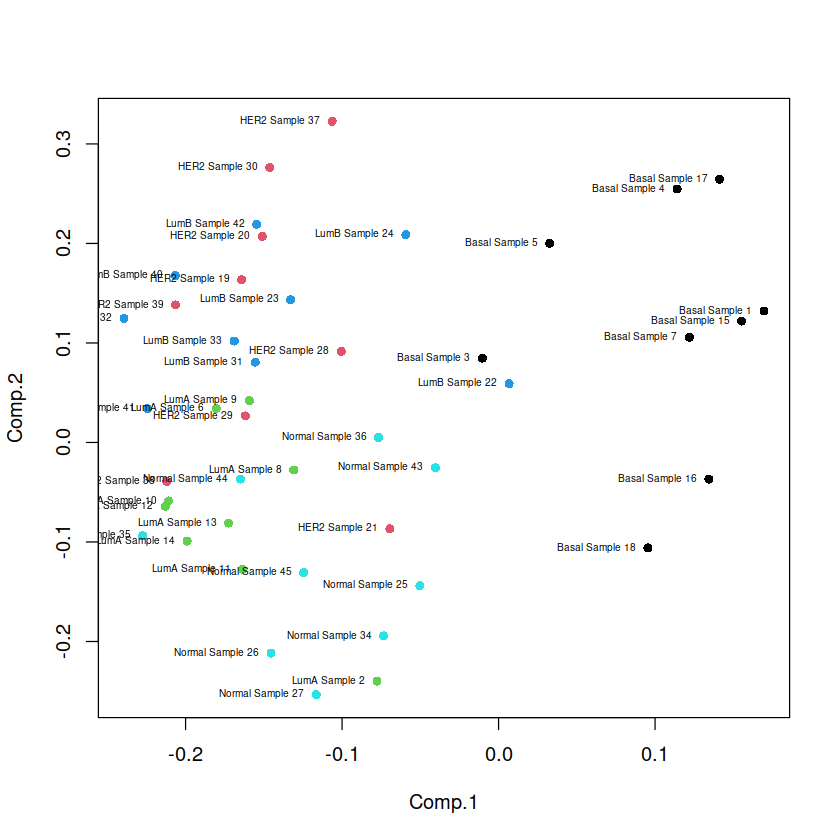

In [54]:
# write into file for usage in  VSClust later on
write.csv(lQuantTable,"resources/data/PMC6453966_VSClust_in.csv")

# PCA for some testing
pca.out <- princomp(QuantTable, cor = T)

#scoring plot
plot(pca.out$loadings, pch=16, col=rep(1:5,each=9) )
text(pca.out$loadings, pos=2, labels=colnames(lQuantTable),cex=0.5)



#### Add your answers here
(double-click here to edit the cell)

##### ❔ Question I:  <ins>How would you interpret a PCA loading plot?</ins>

_Answer_

##### ❔ Question II:  <ins>Can the different cancer subtypes be distinguished? If yes/no, what could be the biological reason? </ins>

_Answer_

##### ❔ Question III:  <ins>Can you predict which subtype should show most of the differences?</ins>

_Answer_



### Hierarchical clustering

This cluster analysis is super-easy in R and provides a nice view of common changes within the proteins. It is used everywhere.

The disadvantage of this clustering method is its limitation to smaller data sets as the plots get very messy for thousands of proteins. Therefore, we will target a subset and cluster it in some examples.

<span style="background-color:#ffdddd;border-left:6px;">Note: The metric is based on a distance matrix, requiring to calculate the distances between each of the features (here proteins). This becomes computationally expensive for very large data sets.</ins>

👨‍💻 You will retrieve the _100 proteins with the largest changes_ of their averaged abundance between the two cancer subtypes. 

The clustering will be carried out for the averaged and the full data. Basing the analysis on averaged values only would neglected biological variance, and thus most likely lead to erronenous interpretations.

[1] "Basal"  "HER2"   "LumA"   "LumB"   "Normal"


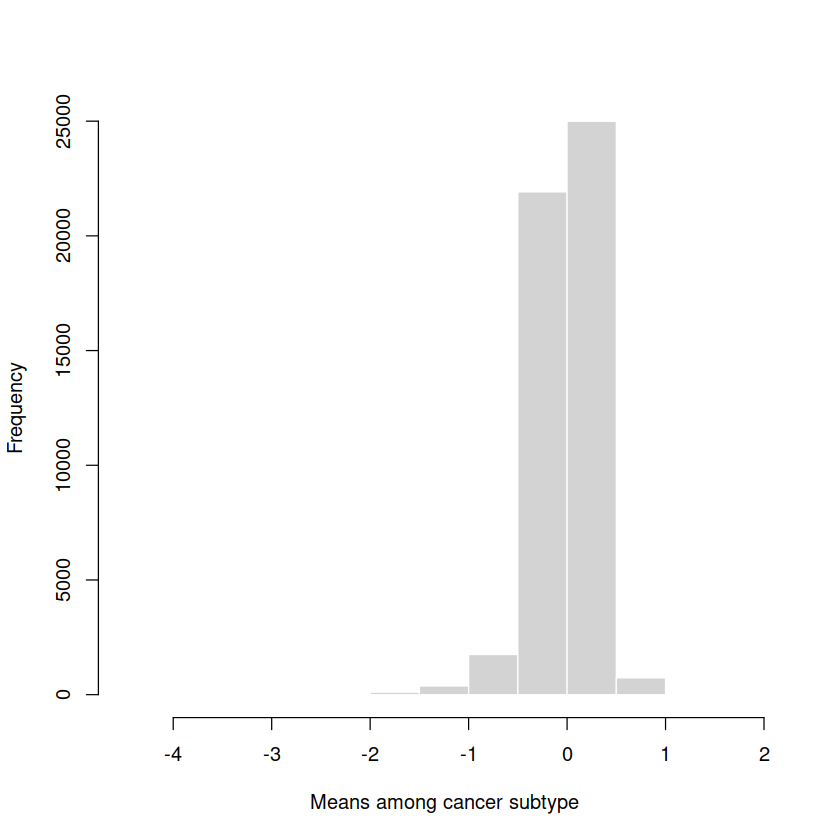

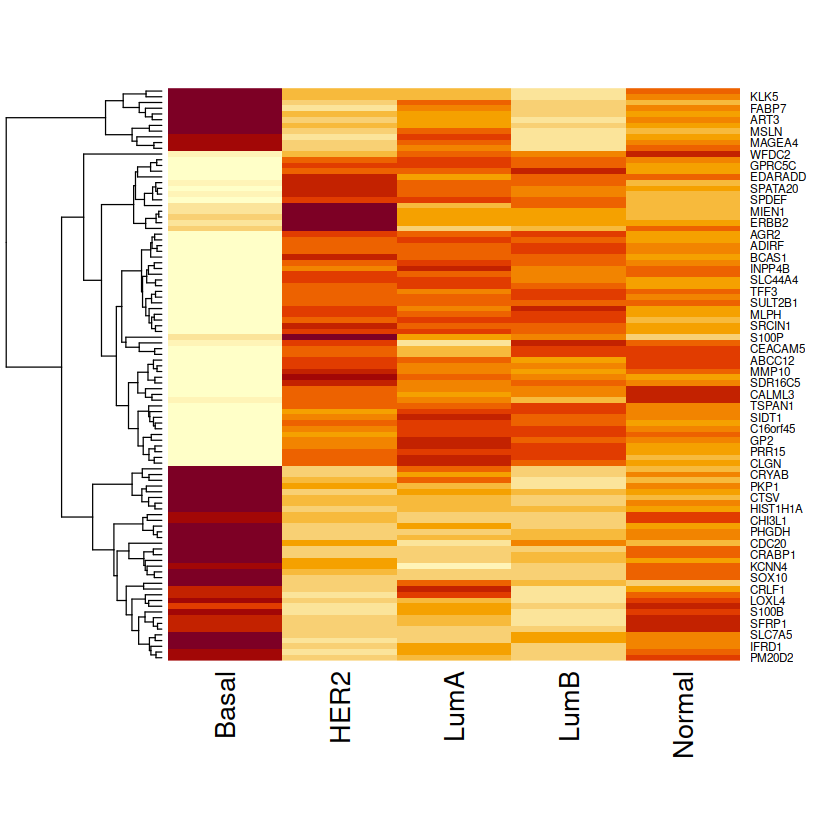

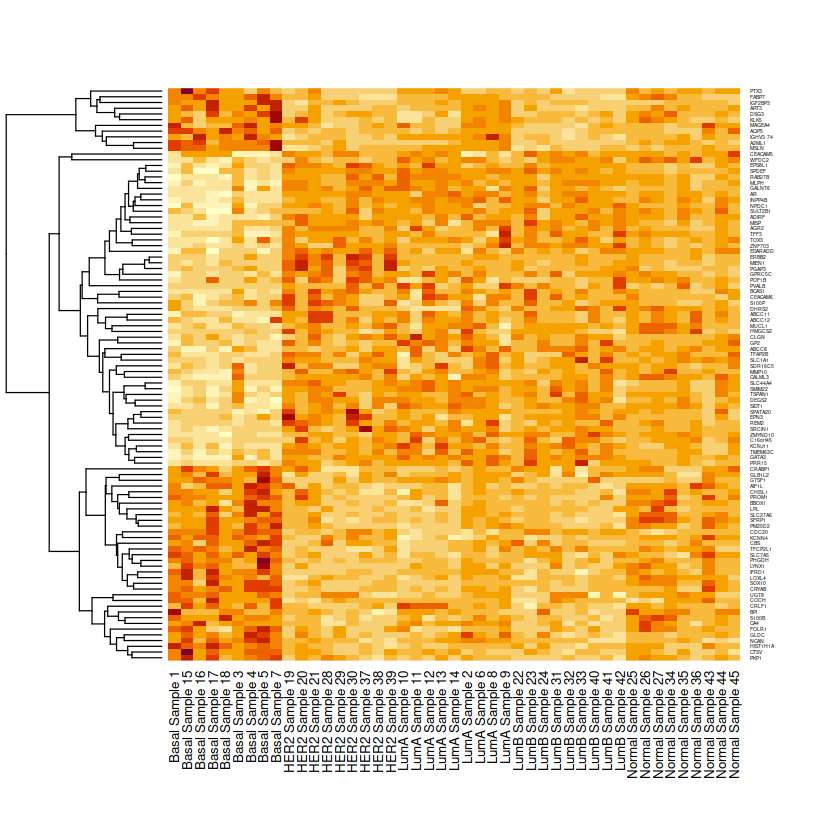

In [61]:
# heat map of the most changing proteins between  the  first 2 conditions

# Calculate means of each cancer subtype
AvQuant <- NULL
for (i in 1:5)
  AvQuant  <- cbind(AvQuant, rowMeans(lQuantTable[,(i-1)*9+(1:9)]))

cancers <- sapply(colnames(lQuantTable), function(x) strsplit(x, " ")[[1]][[1]])
cancers <- unique(cancers)                  
print(cancers)
colnames(AvQuant) <- cancers                  

# Make a histogram of changes between the averages abundances
hist(AvQuant , xlab="Means among cancer subtype", main="", border=0)  

# What happens with the 100 most different proteins?
mostDiffInd <- names(sort(abs(AvQuant[,1] - AvQuant[,2]), decreasing = T)[1:100])
heatmap(AvQuant[mostDiffInd,], Colv=NA)

# Now look on the replicate level (full data). Do you still have the same impression about the significant changes?
heatmap(as.matrix(lQuantTable[mostDiffInd,]), Colv = NA,cexRow = 0.3)


#### Add your answers here
(double-click here to edit the cell)

##### ❔ Question I:  <ins>Which is the expected fold-change of the most changing proteins?</ins>

_Answer_

##### ❔ Question II:  <ins>Is there a difference in the number of proteins increasing/decreasing in the second conditions (within the 100 most changing ones)?</ins>

_Answer_

##### ❔ Question III:  <ins>What does the this command do? `names(sort(abs(AvQuant[,1] - AvQuant[,2]), decreasing = T)[1:100])`</ins>

_Answer_

##### ❔ Question IV:  <ins>Would you still consider the top 100 proteins to show significant changes between the first 2 conditions? Assume an FDR of 1% or 5%</ins>

_Answer_



### Digging deeper into the behavior of one protein

Let's take one of the top 100 proteins (CRABP1) and check its quantitative values as well as its biological function. 

Will it be related to breast cancer? What does a simple Google search tell us?


👨‍💻 Plot its abundance over all replicates and conditions using colors for the different cancer subtypes. 

👨‍💻 Do some search in the web about the function of CRABP1 and whether it is related to any cancer.
Use uniprot.org as starting point. 

👨‍💻 Now search Google for _breast cancer_ and _CRABP1_. 

👨‍💻 Get a random human protein from UniProt:  
https://www.uniprot.org/uniprot/?query=reviewed:yes+AND+organism:9606&random=yes

👨‍💻 + 📓 Look it up again and do also the cancer search on Google. Get the gene name and also plot its quantitative changes.


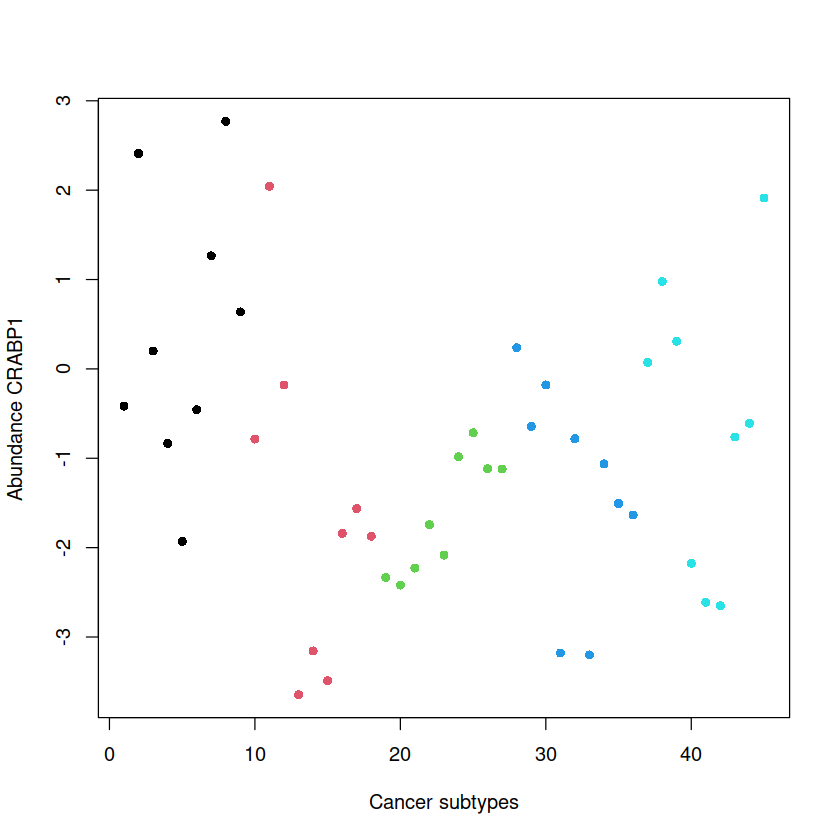

In [62]:
# Take e.g. MUC5B
plot(t(lQuantTable["CRABP1",]), pch=16, col=rep(1:5,each=9), xlab="Cancer subtypes", ylab="Abundance CRABP1")



#### Add your answers here
(double-click here to edit the cell)

##### ❔ Question I:  <ins>The comparison between which conditions is likely to be statistical significant (e.g. with FDR 1%)?</ins>

_Answer_

##### ❔ Question II:  <ins>If the difference between expression in subtypes 1 and 2 is not that evident and might not lead to a significant result from statistical testing? How could you create better evidence?</ins>

_Answer_

##### ❔ Question III:  <ins>Do you consider CRABP1 or the randomly chosen protein to have a stronger relation to breast cancer?</ins>

_Answer_



### Statistics and clustering using VSClust
You will now analyze the quantitative data to VSClust. [VSClust](https://www.ncbi.nlm.nih.gov/pubmed/29635359) is based on fuzzy c-means clustering which is the better version of the well-known k-means clustering. The major difference consists in not assigning a fixed cluster identity to each protein.

Fuzzy c-means is explained e.g. [here](https://home.deib.polimi.it/matteucc/Clustering/tutorial_html/cmeans.html), also in comparison with other clustering methods. 

👨‍💻 There are several possibilities to run the Shiny App:

a) Download the docker image `docker pull veitveit/vsclust` and run  it using `docker run -p3838:3838 veitveit/vsclust`. You can access the app via localhost:3838 in your browser afterwards

b) Run it on the server (here we have a max. of 5 sessions a time): http://computproteomics.bmb.sdu.dk/Apps/VSClust

c) install it via conda: "conda install -c bioconda -c conda-forge vsclust"

👨‍💻 First play with the example and become familiar with the app

👨‍💻 Then upload the csv-file you saved above and get the results from the statistical tests ( _Download q-values and mean log-values_ ).

👨‍💻 Run the estimation of the cluster number. <b>Restrict the maximum to 10 to save time!</b> Look at the plots of the validation indices and the number of proteins that still get assigned to clusters. The variance-sensitive version of the fuzzy c-means account for the uncertainty of a measurement and thus is more stringent in removing proteins with unclear cluster assignments. 

👨‍💻 Run both clustering methods for the suggested number of clusters. 

👨‍💻 Repeat this for a higher number of clusters.

👨‍💻 Redo the analysis by wrongly stating that the replicates are _not_ grouped.

<span style="background-color:#ffdddd;border-left:6px;">Note: Do not run the pathway enrichment when using the app in docker or on the cloud.</span>


#### Add your answers here
(double-click here to edit the cell)

##### ❔ Question I:  <ins>How many proteins are changing significantly between subtypes 1 and 2 (in the app A and B) having a q-value below 0.01? Is CRABP1 one of them? Would you have expected this FDR (q-value) for CRABP1?</ins>

_Answer_

##### ❔ Question II:  <ins>Which cancer subtype is most different from the first one? Does this observation conincide with what you see in the PCA plot?</ins>

_Answer_

##### ❔ Question III:  <ins>How many clusters suggested by the indices? How many proteins (approximately) would you then get in the clusters? How noisy do you consider the dataset? Does the variance-sensitive method filter out many proteins</ins>

_Answer_

##### ❔ Question IV:  <ins>When running the "wrong" experimental design, what is different when looking on statistical results, estimation of cluster number and clustering results?</ins>

_Answer_



### Having a look into GO terms and pathways

👨‍💻 Download the clustering results and upload the proteins of each of the clusters (separately) to [GOrilla](http://cbl-gorilla.cs.technion.ac.il/). 
Do the same uploading them to enrichnet.org

👨‍💻 Take a deeper look into how enrichnet works (e.g. by looking into the tutorial).

#### Add your answers here
(double-click here to edit the cell)

##### ❔ Question I:  <ins>How many cluster members do you get? What are the main trends when comparing all cancer subtypes?</ins>

_Answer_

##### ❔ Question II:  <ins>Do you get the same result for the GO term enrichment? If not, what could be the reason?</ins>

_Answer_

##### ❔ Question III:  <ins>Any useful biology coming out? Check the original paper for the specific cancer subtypes.</ins>

_Answer_



#### Add your answers here
(double-click here to edit the cell)

##### ❔ Question I:  <ins></ins>

_Answer_

##### ❔ Question II:  <ins>?</ins>

_Answer_

##### ❔ Question II:  <ins>?</ins>

_Answer_

